In [64]:
import os
import glob

import numpy as np
import astropy.constants as c
import astropy.units as u
from astropy.modeling import models, fitting
from astropy.convolution import convolve, Box1DKernel
from astropy.io import fits

from specutils.io import read_fits

from matplotlib import pyplot as plt
%matplotlib

import supernova
import spectroscopy

Using matplotlib backend: Qt5Agg


In [45]:
DATA_DIR = '../data/spectra/lco/'
FIG_DIR = '../figures'

In [46]:
flist = glob.glob(os.path.join(DATA_DIR, '*.fits'))
date_obs = []
for ifile in flist:
    date_obs.append(fits.getval(ifile, 'date-obs', 0))
date_obs.sort()
for idate in date_obs:
    print(idate)
for ifile in flist:
    print(ifile)

2015-09-04T12:22:16.314
2015-09-04T12:22:16.314
2015-09-06T10:50:42.698
2015-09-06T10:50:42.698
2015-09-06T10:50:42.698
2015-09-06T10:50:42.698
2015-09-06T10:50:42.698
2015-09-07T12:38:35.277
2015-09-07T12:38:35.277
2015-09-11T10:53:36.349
2015-09-11T10:53:36.349
2015-09-16T12:09:11.274
2015-09-16T12:09:11.274
2015-09-16T12:09:11.274
2015-09-20T13:50:34.512
2015-09-20T13:50:34.512
2015-09-24T12:38:47.580
2015-09-24T12:38:47.580
2015-09-30T12:28:58.217
2015-09-30T12:28:58.217
2015-10-06T10:19:06.800
2015-10-06T10:19:06.800
2015-10-14T11:29:18.305
2015-10-14T11:29:18.305
2015-10-14T11:29:18.305
2015-10-25T10:22:21.833
2015-10-25T10:22:21.833
2015-11-07T10:12:10.833
2015-11-07T10:12:10.833
2015-11-07T10:12:10.833
../data/spectra/lco/asassn-15oz_20150906_redblu_105042.698.fits
../data/spectra/lco/asassn-15oz_20150906_redblu_105042.698_multi.fits
../data/spectra/lco/asassn-15oz_20150906_redblu_105042.698a.fits
../data/spectra/lco/asassn-15oz_20150906_redblu_105042.698a_multi.fits
../data/sp

In [47]:
sn15oz = supernova.LightCurve2('ASASSN-15oz')
sn15oz.redshift = 0.006931 #Ref: NED object: HIPASS J1919-33
spec = read_fits.read_fits_spectrum1d(os.path.join(DATA_DIR, 'asassn15oz_20151006_redblu_101906.800.fits'))[0]

In [6]:
spec.rest_wl = spectroscopy.apply_redshift(spec.dispersion, sn15oz.redshift)

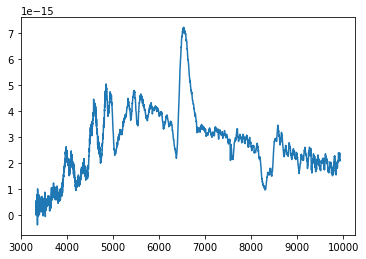

In [7]:
plt.plot(spec.rest_wl, spec.flux)

In [8]:
lines={
    'HeI':[4471,5015,5876,6678,7065,7283,10833.,20587.],
    'HeII':[4685,5411],
    'FeII-multi':[4173.46, 4178.98, 4180.98, 4233.17, 4296.57, 4303.18, 4351.77, 
            4508.29, 4522.63, 4549.47, 4555.89, 4589.84, 4629.34,
           4923.93, 5018.44, 5169.03, 5197.58, 5234.62, 5276.00, 5316.62, 
           5325.55, 5414.07, 5425.26, 5432.97, 5534.85, 6147.74, 6149.26, 6238.39, 6247.56],
    'FeII-single': [4244,4276,4416,4458,4814,4890,5159,5220,5261,5273,5333,7155,7172,7388,7452],
    'OI':[6157.,7254.,7773.5,7990.,8222.,8446.,9266.,11290.], #7773.5 is actually a doublet: 7772.,7775. But its always blended so we fit it as one
    'OII':[6695,6898.,13811.,21085.],
    'OIII':[3759,5006,4958,4602],  #This would be unusual
    'OV':[5592.],
    'OVI':[3811,3834],
    'CaII':[3934.,3968.,8498.,8542.,8662.,11876.,8921.,8235.,9906.],
    'NaID':[5890.,5896.],
    'BaII':[5854,6142,6497],
    'ScII-single':[4670.,5527.,5658,6245.,],
    'ScII-multi':[4246.82, 4314.08, 4320.73, 4325.00, 4374.46, 4400.39,
                 4415.56, 4670.41, 5031.02, 5239.81, 5526.79, 5641.00,
                 5657.90, 5658.36, 5667.15, 5669.04, 5684.20, 6279.75],
    'SiII':[4130.,5051.,5972.,6355.],
    'SiI':[15893.],
    'SrII': [4077.71, 4305.44],
    'CII':[6580.,7235.,18905.,178446.,9903.],
    'CI':[10693.,9087.,9406.,9639.,14543.,11756.,8333.,12614.,13502.,16600.,16890.],
    'MgII':[4481.,7890.,8228.,9227.,21376.,10927.,7890.,8228.,10092.],
    'MgI':[4571.,5183.,5711.,7659.,8213.,8924.,8736.,9415.,9256.,9246.5],
    'Balmer':[3970.1,4101.7,4340.5,4861.3,6562.8],
    '[FeII]':[4244,4276,4416,4458,4814,4890,5159,5220,5261,5273,5333,7155,7172,7388,7452],
    '[CaII]':[7291,7324]}


In [127]:
def plot_lines(species, velocity, ax, blueshift=True, color='gray', ls='-', alpha=0.75):
    '''
    Given an species, blue (red) shift by velocity and plot on ax
    species must be a key in lines
    velocity is specified in km/s
    ax should be a matplotlib subplot or axes object
    if blueshift is True rest wavelengths will be blueshifted by the velocity
    '''
    if species in lines.keys():
        if blueshift is True:
            velocity = -velocity
            
        new_wl = np.array(lines[species])*(velocity/(c.c.to(u.km/u.s).value) + 1)
    else:
        print('{} not in dictionary keys, {}'.format(species, lines.keys()))
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    ax.vlines(new_wl, *ylim, color=color, label='{}-{}km/s'.format(species, velocity), linestyle=ls, alpha=alpha)
    ax.set_xlim(xlim)
    return new_wl

# 10-06-2015

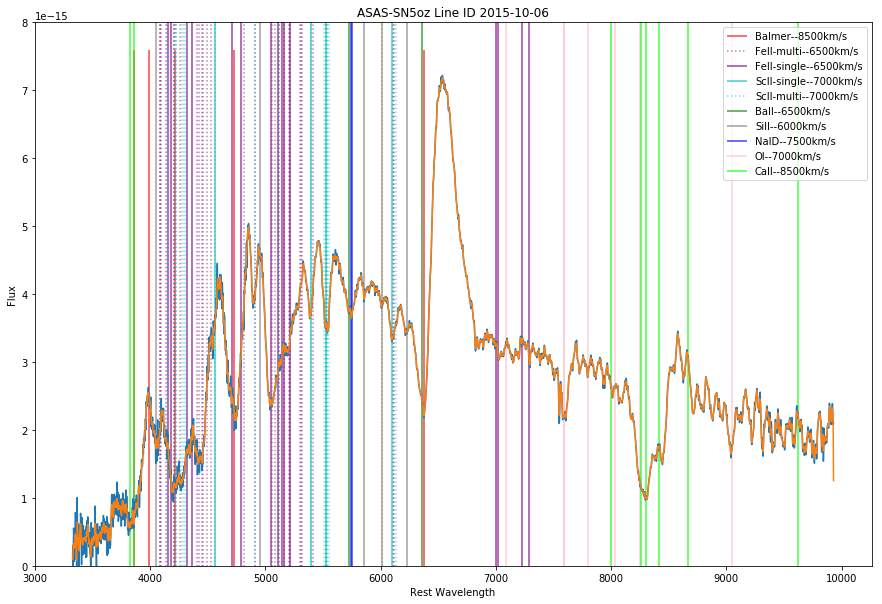

In [144]:
spec = read_fits.read_fits_spectrum1d(os.path.join(DATA_DIR, 'asassn15oz_20151006_redblu_101906.800.fits'))[0]
spec.rest_wl = spectroscopy.apply_redshift(spec.dispersion, sn15oz.redshift)
npix_smooth = 5
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
ax.plot(spec.rest_wl, spec.flux)
ax.plot(spec.rest_wl, convolve(spec.flux, Box1DKernel(npix_smooth)))
Ha = plot_lines('Balmer', 8500, ax, color = 'r')

feII_multi = plot_lines('FeII-multi', 6500, ax, color='purple', alpha=0.5, ls=':')
feII_single = plot_lines('FeII-single', 6500, ax, color='purple')
scII_single = plot_lines('ScII-single', 7000, ax, color='c')
scII_multi = plot_lines('ScII-multi', 7000, ax, color='c', alpha=0.5, ls=':')
baII = plot_lines('BaII', 6500, ax, color='g')
siII = plot_lines('SiII', 6000, ax, color='gray')
naI = plot_lines('NaID', 7500, ax, color='b')
oI = plot_lines('OI', 7000, ax, color='pink')
caII = plot_lines('CaII', 8500, ax, color='lime')
#plot_lines('SrII', 7000, ax, color='lime')
#plot_lines('HeI', 7000, ax, color='cyan')
#cI = plot_lines('CI', 7000, ax, color='gold')
#cII = plot_lines('CII', 7000, ax, color='gold')
#mgII = plot_lines('MgII', 7000, ax, color='gold')

plt.legend(loc='best')
#ax.set_xlim(3500, 8000)
ax.set_ylim(0, 0.8E-14)
ax.set_xlabel('Rest Wavelength')
ax.set_ylabel('Flux')
ax.set_title('ASAS-SN5oz Line ID 2015-10-06')
plt.savefig(os.path.join(FIG_DIR,'line_id_20151006.pdf'))


# 09-30-2015

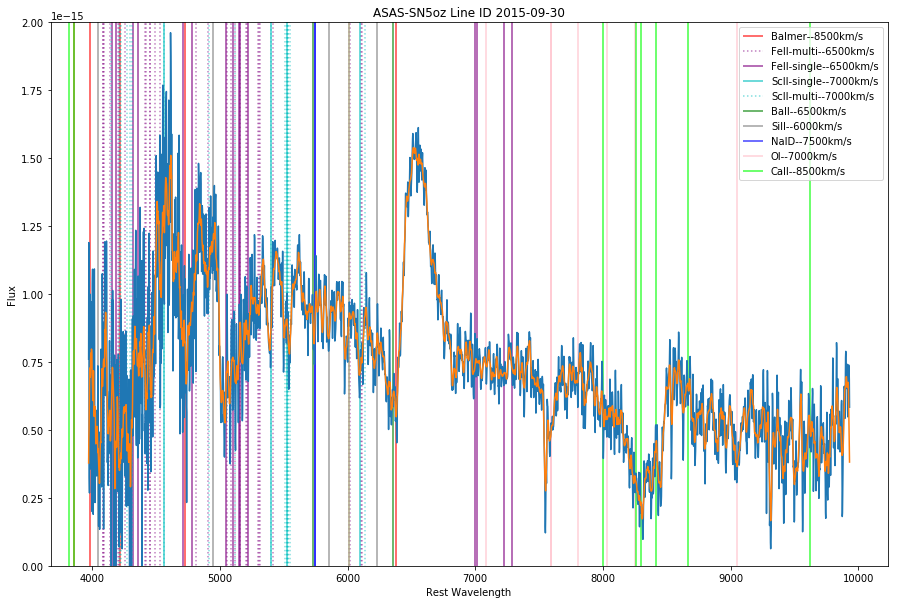

In [141]:
spec = read_fits.read_fits_spectrum1d(os.path.join(DATA_DIR, 'asassn-15oz_20150930_redblu_122858.217.fits'))[0]
spec.rest_wl = spectroscopy.apply_redshift(spec.dispersion, sn15oz.redshift)

npix_smooth = 11
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
ax.plot(spec.rest_wl, spec.flux)
ax.plot(spec.rest_wl, convolve(spec.flux, Box1DKernel(npix_smooth)))
Ha = plot_lines('Balmer', 8500, ax, color = 'r')

feII_multi = plot_lines('FeII-multi', 6500, ax, color='purple', alpha=0.5, ls=':')
feII_single = plot_lines('FeII-single', 6500, ax, color='purple')
scII_single = plot_lines('ScII-single', 7000, ax, color='c')
scII_multi = plot_lines('ScII-multi', 7000, ax, color='c', alpha=0.5, ls=':')
baII = plot_lines('BaII', 6500, ax, color='g')
siII = plot_lines('SiII', 6000, ax, color='gray')
naI = plot_lines('NaID', 7500, ax, color='b')
oI = plot_lines('OI', 7000, ax, color='pink')
caII = plot_lines('CaII', 8500, ax, color='lime')
#plot_lines('SrII', 7000, ax, color='lime')
#plot_lines('HeI', 7000, ax, color='cyan')
#cI = plot_lines('CI', 7000, ax, color='gold')
#cII = plot_lines('CII', 7000, ax, color='gold')
#mgII = plot_lines('MgII', 7000, ax, color='gold')

plt.legend(loc='best')
#ax.set_xlim(3500, 8000)
ax.set_ylim(0, 0.2E-14)
ax.set_xlabel('Rest Wavelength')
ax.set_ylabel('Flux')
ax.set_title('ASAS-SN5oz Line ID 2015-09-30')
plt.savefig(os.path.join(FIG_DIR,'line_id_20150930.pdf'))

# 09-24-2015

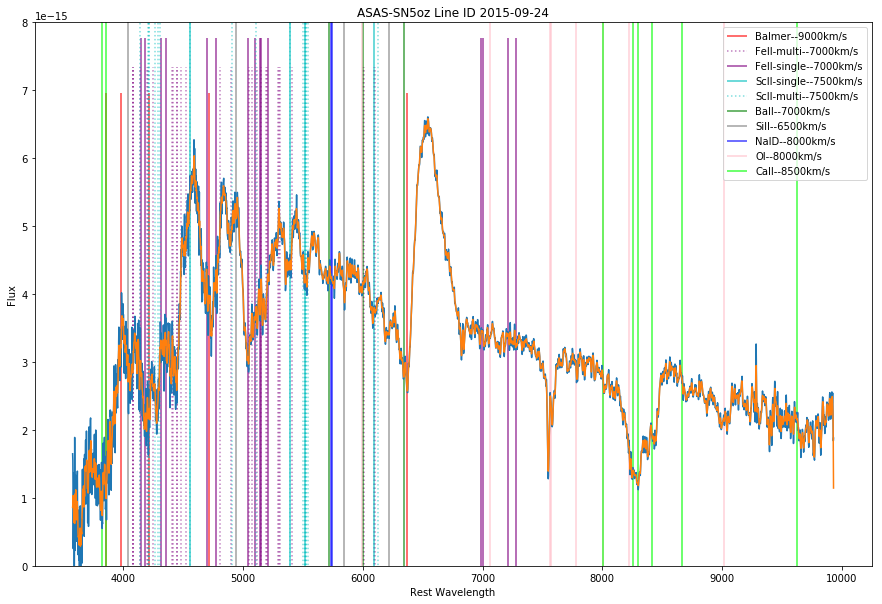

In [142]:
spec = read_fits.read_fits_spectrum1d(os.path.join(DATA_DIR, 'asassn-15oz_20150924_redblu_123847.580.fits'))[0]
spec.rest_wl = spectroscopy.apply_redshift(spec.dispersion, sn15oz.redshift)

npix_smooth = 5
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
ax.plot(spec.rest_wl, spec.flux)
ax.plot(spec.rest_wl, convolve(spec.flux, Box1DKernel(npix_smooth)))
Ha = plot_lines('Balmer', 9000, ax, color = 'r')

feII_multi = plot_lines('FeII-multi', 7000, ax, color='purple', alpha=0.5, ls=':')
feII_single = plot_lines('FeII-single', 7000, ax, color='purple')
scII_single = plot_lines('ScII-single', 7500, ax, color='c')
scII_multi = plot_lines('ScII-multi', 7500, ax, color='c', alpha=0.5, ls=':')
baII = plot_lines('BaII', 7000, ax, color='g')
siII = plot_lines('SiII', 6500, ax, color='gray')
naI = plot_lines('NaID', 8000, ax, color='b')
oI = plot_lines('OI', 8000, ax, color='pink')
caII = plot_lines('CaII', 8500, ax, color='lime')
#plot_lines('SrII', 7000, ax, color='lime')
#plot_lines('HeI', 7000, ax, color='cyan')
#cI = plot_lines('CI', 7000, ax, color='gold')
#cII = plot_lines('CII', 7000, ax, color='gold')
#mgII = plot_lines('MgII', 7000, ax, color='gold')

plt.legend(loc='best')
#ax.set_xlim(3500, 8000)
ax.set_ylim(0, 0.8E-14)
ax.set_xlabel('Rest Wavelength')
ax.set_ylabel('Flux')
ax.set_title('ASAS-SN5oz Line ID 2015-09-24')
plt.savefig(os.path.join(FIG_DIR,'line_id_20150924.pdf'))

# 09-20-2015

# 09-16-2015

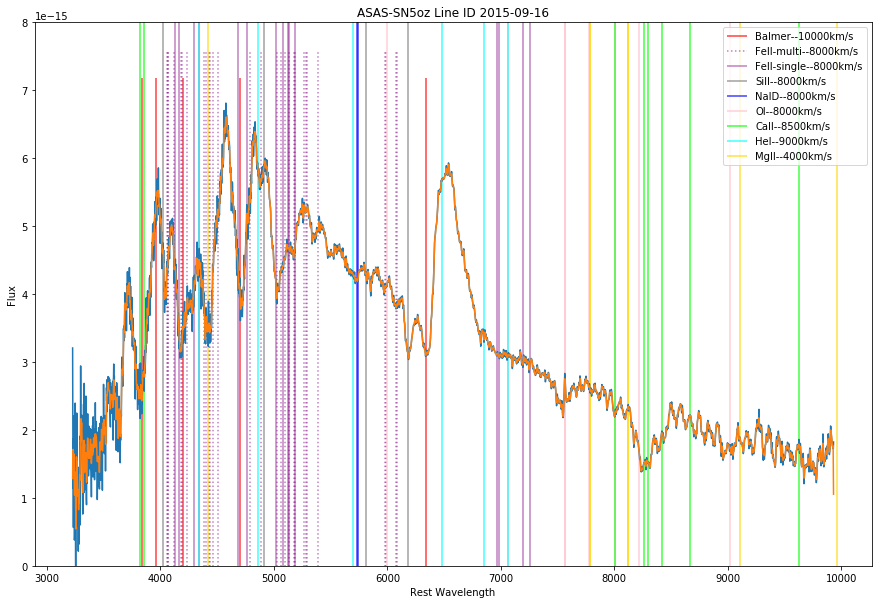

In [140]:
spec = read_fits.read_fits_spectrum1d(os.path.join(DATA_DIR, 'asassn15oz_20150916_redblu_120911.274.fits'))[0]
spec.rest_wl = spectroscopy.apply_redshift(spec.dispersion, sn15oz.redshift)

npix_smooth = 5
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
ax.plot(spec.rest_wl, spec.flux)
ax.plot(spec.rest_wl, convolve(spec.flux, Box1DKernel(npix_smooth)))
Ha = plot_lines('Balmer', 10000, ax, color = 'r')

feII_multi = plot_lines('FeII-multi', 8000, ax, color='purple', alpha=0.5, ls=':')
feII_single = plot_lines('FeII-single', 8000, ax, color='purple', alpha=0.5)
##scII_single = plot_lines('ScII-single', 9000, ax, color='g')
##scII_multi = plot_lines('ScII-multi', 9000, ax, color='g', alpha=0.5, ls=':')
##baII = plot_lines('BaII', 7000, ax, color='g')
siII = plot_lines('SiII', 8000, ax, color='gray')
naI = plot_lines('NaID', 8000, ax, color='b')
oI = plot_lines('OI', 8000, ax, color='pink')
caII = plot_lines('CaII', 8500, ax, color='lime')
##plot_lines('SrII', 7000, ax, color='lime')
plot_lines('HeI', 9000, ax, color='cyan')
##plot_lines('HeII', 9000, ax, color='lime')
##cI = plot_lines('CI', 7000, ax, color='gold')
##cII = plot_lines('CII', 9000, ax, color='gold')
mgII = plot_lines('MgII', 4000, ax, color='gold')
#mgI = plot_lines('MgI', 9000, ax, color='lime')
#oIII = plot_lines('OIII', 9000, ax, color = 'pink')

plt.legend(loc='best')
#ax.set_xlim(3500, 8000)
ax.set_ylim(0, 0.8E-14)
ax.set_xlabel('Rest Wavelength')
ax.set_ylabel('Flux')
ax.set_title('ASAS-SN5oz Line ID 2015-09-16')
plt.savefig(os.path.join(FIG_DIR,'line_id_20150916.pdf'))

# 09-11-2015

# 09-07-2015

# 09-04-2015

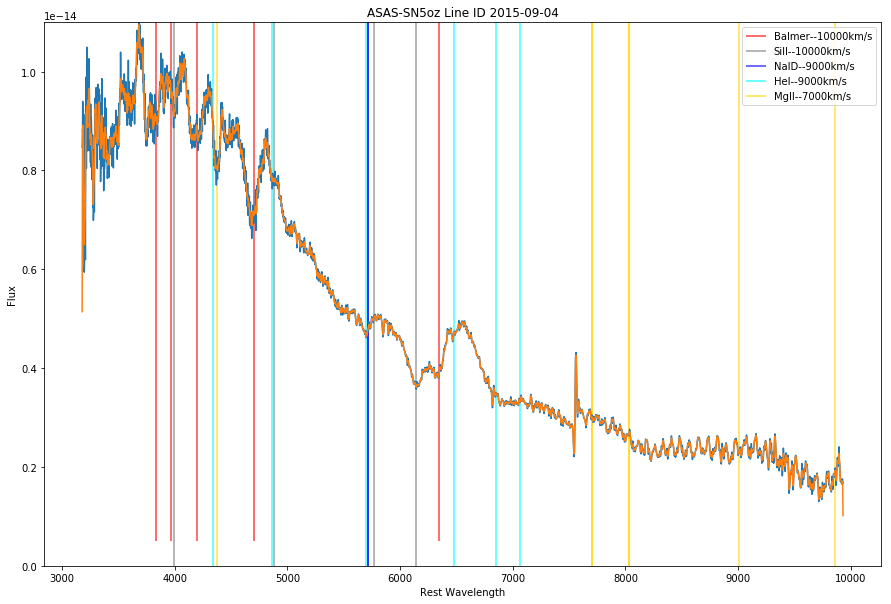

In [146]:
spec = read_fits.read_fits_spectrum1d(os.path.join(DATA_DIR, 'asassn15oz_20150904_redblu_122216.314.fits'))[0]
spec.rest_wl = spectroscopy.apply_redshift(spec.dispersion, sn15oz.redshift)

npix_smooth = 5
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
ax.plot(spec.rest_wl, spec.flux)
ax.plot(spec.rest_wl, convolve(spec.flux, Box1DKernel(npix_smooth)))
Ha = plot_lines('Balmer', 10000, ax, color = 'r')

#feII_multi = plot_lines('FeII-multi', 9000, ax, color='purple', alpha=0.5, ls=':')
##feII_single = plot_lines('FeII-single', 9000, ax, color='purple', alpha=0.5)
##scII_single = plot_lines('ScII-single', 9000, ax, color='g')
##scII_multi = plot_lines('ScII-multi', 9000, ax, color='g', alpha=0.5, ls=':')
##baII = plot_lines('BaII', 7000, ax, color='g')
siII = plot_lines('SiII', 10000, ax, color='gray')
naI = plot_lines('NaID', 9000, ax, color='b')
##oI = plot_lines('OI', 8000, ax, color='pink')
##caII = plot_lines('CaII', 8500, ax, color='lime')
##plot_lines('SrII', 7000, ax, color='lime')
plot_lines('HeI', 9000, ax, color='cyan')
##plot_lines('HeII', 9000, ax, color='lime')
##cI = plot_lines('CI', 7000, ax, color='gold')
##cII = plot_lines('CII', 9000, ax, color='purple')
mgII = plot_lines('MgII', 7000, ax, color='gold')
#mgI = plot_lines('MgI', 9000, ax, color='lime')
##oII = plot_lines('OII', 9000, ax, color = 'pink')

plt.legend(loc='best')
#ax.set_xlim(3500, 8000)
ax.set_ylim(0, 1.1E-14)
ax.set_xlabel('Rest Wavelength')
ax.set_ylabel('Flux')
ax.set_title('ASAS-SN5oz Line ID 2015-09-04')
plt.savefig(os.path.join(FIG_DIR,'line_id_20150904.pdf'))

In [21]:
from astropy.modeling.models import custom_model
#https://gist.github.com/cheekujodhpur/7fe40a87b6732a0d864ab8146bb8c096
@custom_model
def blackbody(wavelength, temperature=2000):
    wavelength = u.Quantity(wavelength, "Angstrom")
    temperature = u.Quantity(temperature, "K")
    max_val = blackbody_lambda((c.b_wien/temperature).to(u.Angstrom),temperature).value
    return blackbody_lambda(wavelength, temperature).value/max_val

In [357]:
def tie_ba_ab2(model):
    return model.mean_3+281.75
def tie_ba_ab3(model):
    return model.mean_3+629.05

bb = blackbody(temperature=5000)
ha_emission = models.Gaussian1D(mean=6560, stddev=300, amplitude=1)
ha_absorp = models.Const1D(0.4) - models.Gaussian1D(mean=6400, stddev=50, amplitude=0.2) 
em1 = models.Gaussian1D(mean=4800, stddev=50)
em2 = models.Gaussian1D(mean=4600, stddev=50)


fit = fitting.LevMarLSQFitter()
model_spec = bb+ha_emission+ha_absorp+em1+em2
#-ba_absorp1 - ba_absorp2 - ba_absorp3
#model_spec.mean_4.tied=tie_ba_ab2
#model_spec.mean_5.tied=tie_ba_ab3
scale = np.max(spec.flux.value[(spec.rest_wl.value<6000)|(spec.rest_wl.value>7000)])
F = fit(model_spec, spec.rest_wl.value, spec.flux.value/scale)

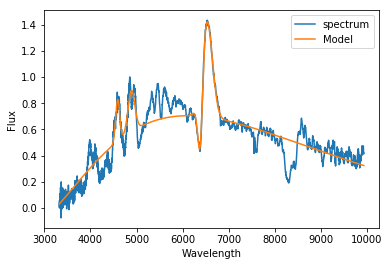

In [358]:
plt.plot(spec.rest_wl, spec.flux/scale, label='spectrum')
plt.plot(spec.rest_wl, F(spec.rest_wl.value), label='Model')
plt.xlabel("Wavelength")
plt.ylabel('Flux')
plt.legend()
plt.savefig(os.path.join(FIG_DIR,'spec_model.pdf'))

In [341]:
print(F)

Model: CompoundModel223
Inputs: ('wavelength',)
Outputs: ('wavelength',)
Model set size: 1
Expression: [0] + [1] + [2] - [3]
Components: 
    [0]: <blackbody(temperature=5000.0)>

    [1]: <Gaussian1D(amplitude=1.0, mean=6560.0, stddev=300.0)>

    [2]: <Const1D(amplitude=0.4)>

    [3]: <Gaussian1D(amplitude=0.2, mean=6400.0, stddev=50.0)>
Parameters:
    temperature_0  amplitude_1      mean_1    ...    mean_3       stddev_3  
    ------------- ------------- ------------- ... ------------ -------------
    4820.21274572 0.74440394483 6522.16821453 ... 6383.4423427 58.5107282179


In [241]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

spectra = spec.flux.value

print("Data loaded...")

from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.units import Quantity
from astropy import units
from astropy.modeling.blackbody import blackbody_lambda
from astropy.constants import b_wien

@custom_model
def blackbody(wavelength, temperature=2000):
    wavelength = Quantity(wavelength, "Angstrom")
    temperature = Quantity(temperature, "K")
    max_val = blackbody_lambda((b_wien/temperature).to(units.Angstrom),temperature).value
    return blackbody_lambda(wavelength, temperature).value/max_val

x = np.linspace(1150,25000,len(spectra))
y = spectra
y = spectra/np.max(spectra)

init = blackbody(temperature=2000)
fit = fitting.LevMarLSQFitter()
F = fit(init, x, y)

print(F)

Data loaded...
Model: blackbody
Inputs: ('wavelength',)
Outputs: ('wavelength',)
Model set size: 1
Parameters:
     temperature 
    -------------
    3330.02149225


In [255]:
models.Const1D?

In [286]:
baII[2]-baII[0]

629.05868864119293

In [ ]:
ba_absorp1.